## Predict Tm using embeddings from ProteinMPNN
- Then see if combining esm2 embeddings with proteinMPNN will further improve things

### First download structures for each protein

In [ ]:
import json, time, os, sys, glob, re
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm, trange
tqdm.pandas()

# git clone https://github.com/dauparas/ProteinMPNN.git"
# add to path
base_dir = "/projects/bpms/jlaw/tools/ProteinMPNN"
sys.path.append(base_dir)

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Setup Model
import warnings
import torch
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split, Subset
import copy
import torch.nn as nn
import torch.nn.functional as F
import random
import os.path
from protein_mpnn_utils import loss_nll, loss_smoothed, gather_edges, gather_nodes, gather_nodes_t, cat_neighbors_nodes, _scores, _S_to_seq, tied_featurize, parse_PDB
from protein_mpnn_utils import StructureDataset, StructureDatasetPDB, StructureLoader, ProteinMPNN

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
#v_48_010=version with 48 edges 0.10A noise
model_name = "v_48_010" #@param ["v_48_002", "v_48_010", "v_48_020", "v_48_030"]

# Standard deviation of Gaussian noise to add to backbone atoms
backbone_noise=0.0  

path_to_model_weights = f'{base_dir}/vanilla_model_weights'          
hidden_dim = 128
num_layers = 3 
model_folder_path = path_to_model_weights
if model_folder_path[-1] != '/':
    model_folder_path = model_folder_path + '/'
checkpoint_path = model_folder_path + f'{model_name}.pt'

checkpoint = torch.load(checkpoint_path, map_location=device) 
print('Number of edges:', checkpoint['num_edges'])
noise_level_print = checkpoint['noise_level']
print(f'Training noise level: {noise_level_print}A')
model = ProteinMPNN(num_letters=21, node_features=hidden_dim, edge_features=hidden_dim, hidden_dim=hidden_dim, num_encoder_layers=num_layers, num_decoder_layers=num_layers, augment_eps=backbone_noise, k_neighbors=checkpoint['num_edges'])
model.to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print("Model loaded")

In [ ]:
inputs_dir = Path("/projects/robustmicrob/jlaw/inputs/")

### Load the meltome atlas data

In [ ]:
# try using the same train/test splits that flip used
df_split = pd.read_csv(Path(inputs_dir, "meltome/flip/github/splits/mixed_split.csv"))
print(len(df_split))
df_split.head(2)

### Extracting ProteinMPNN Embeddings

In [ ]:
def read_embeddings(embed_file, sequence_idx_file):
    """ Read embeddings stored in an npz file
    Get the sequences at each index from the *sequence_idx_file
    """
    embeddings = np.load(embed_file, allow_pickle=True)['arr_0']
    sequences = pd.read_csv(sequence_idx_file)
    print(f"{len(embeddings) = } read from {embed_file}")
    print(f"{len(sequences) = } read from {sequence_idx_file}")
    return embeddings, sequences

### Try using attention on the proteinmpnn AA embeddings

In [ ]:
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge

import pytorch_lightning as pl
import torchmetrics

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint


# copied from here: https://github.com/microsoft/protein-sequence-models/blob/main/sequence_models/convolutional.py
class MaskedConv1d(nn.Conv1d):
    """ A masked 1-dimensional convolution layer.
    Takes the same arguments as torch.nn.Conv1D, except that the padding is set automatically.
         Shape:
            Input: (N, L, in_channels)
            input_mask: (N, L, 1), optional
            Output: (N, L, out_channels)
    """

    def __init__(self, in_channels: int, out_channels: int,
                 kernel_size: int, stride: int=1, dilation: int=1, groups: int=1,
                 bias: bool=True):
        """
        :param in_channels: input channels
        :param out_channels: output channels
        :param kernel_size: the kernel width
        :param stride: filter shift
        :param dilation: dilation factor
        :param groups: perform depth-wise convolutions
        :param bias: adds learnable bias to output
        """
        padding = dilation * (kernel_size - 1) // 2
        super().__init__(in_channels, out_channels, kernel_size, stride=stride, dilation=dilation,
                                           groups=groups, bias=bias, padding=padding)

    def forward(self, x, input_mask=None):
        if input_mask is not None:
            x = x * input_mask
        return super().forward(x.transpose(1, 2)).transpose(1, 2)
    

# copied from here: https://github.com/microsoft/protein-sequence-models/blob/main/sequence_models/structure.py
class Attention1d(nn.Module):
    
    def __init__(self, in_dim):
        super().__init__()
        self.layer = MaskedConv1d(in_dim, 1, 1)

    def forward(self, x, input_mask=None):
        n, ell, _ = x.shape
        attn = self.layer(x)
        attn = attn.view(n, -1)
        if input_mask is not None:
            attn = attn.masked_fill_(~input_mask.view(n, -1).bool(), float('-inf'))
        attn = F.softmax(attn, dim=-1).view(n, -1, 1)
        out = (attn * x).sum(dim=1)
        return out
    
    
# copied from here: https://github.com/J-SNACKKB/FLIP/blob/main/baselines/models.py
class ESMAttention1d(pl.LightningModule):
    """Outputs of the ESM model with the attention1d"""
    def __init__(self, max_length, d_embedding): # [batch x sequence(751) x embedding (1280)] --> [batch x embedding] --> [batch x 1]
        super(ESMAttention1d, self).__init__()
        self.attention1d = Attention1d(in_dim=d_embedding) # ???
        self.linear = nn.Linear(d_embedding, d_embedding)
        self.relu = nn.ReLU()
        self.final = nn.Linear(d_embedding, 1)
    
    def forward(self, x):
        x = self.attention1d(x)
        x = self.relu(self.linear(x))
        x = self.final(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y, mask = batch

        y_pred = self(x).squeeze(1)
        # y_pred = y_pred[mask]
        # y2 = y[mask]
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
class NeuralNetwork(pl.LightningModule):
    def __init__(self, initial_layer_size=1280):
        super(NeuralNetwork, self).__init__()
        second_layer_size = initial_layer_size // 2
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(initial_layer_size, second_layer_size),
            nn.ReLU(),            
            nn.Linear(second_layer_size, second_layer_size),
            nn.ReLU(),
            nn.Linear(second_layer_size, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits    

    def training_step(self, batch, batch_idx):
        x, y, mask = batch

        y_pred = self(x).squeeze(1)
        # y_pred = y_pred[mask]
        # y2 = y[mask]
        loss = nn.functional.mse_loss(y_pred, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, mask = batch
        y_pred = self(x).squeeze(1)
        loss = nn.functional.mse_loss(y_pred, y)        
        self.log("val_loss", loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
def fit_model_att(X_train, y_train, y_mask, X_valid):
    pl.seed_everything(42)
    esm_model = ESMAttention1d(1500, X_train.shape[-1])
    
    trainer = pl.Trainer(
        # gpus=-1,
        # devices=0,
        accelerator="gpu",
        max_epochs=20,
        check_val_every_n_epoch=5)

    train_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_train).to(device), 
    # train_dataset = torch.utils.data.TensorDataset(X_train.to(device), 
                                                   torch.Tensor(y_train).to(device), 
                                                   torch.BoolTensor(y_mask))
    # valid_dataset = torch.utils.data.TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)

    trainer.fit(esm_model, train_loader)
    
    return esm_model

In [ ]:
max_seq_length = 1500

In [ ]:
# These embeddings take up much more space
protmpnn_aa_embed, df_seq = read_embeddings(Path(inputs_dir, "structures/embeddings/20230221_aa_embeddings_v_48_010.npz"),
                                            Path(inputs_dir, "structures/embeddings/20230221_aa_embeddings_v_48_010.csv"))
protmpnn_aa_embed = torch.Tensor(protmpnn_aa_embed)
# mask = protmpnn_aa_embed != 0
# protmpnn_aa_embed = torch.masked.as_masked_tensor(protmpnn_aa_embed, mask)
protmpnn_aa_seq = df_seq.sequence.values
# map from the sequence to the idx to access the correct row in the matrix
seq_idx = {seq: i for i, seq in enumerate(protmpnn_aa_seq)}
protmpnn_aa_embed.shape

In [ ]:
df_seq.head(2)

In [ ]:
df_split_w_embed2 = df_split[df_split.sequence.isin(seq_idx)]
print(len(df_split_w_embed2))

In [ ]:
seqs = df_split_w_embed2.sequence.unique()
len(seqs)

In [ ]:
# del X_train, X_test, protmpnn_aa_embed

In [ ]:
df_train = df_split_w_embed2[df_split_w_embed2.set == "train"]
print(len(df_train), f"{len(df_train) / len(df_split_w_embed2):0.2f}")

# some of the sequences are repeated, so get their embeddings by index
# X_train = np.asarray([protmpnn_aa_embed[seq_idx[seq]] for seq in df_train.sequence.values])
X_train = protmpnn_aa_embed[[seq_idx[seq] for seq in df_train.sequence.values]]
y_train = df_train.target.values

df_test = df_split_w_embed2[df_split_w_embed2.set == "test"]
print(len(df_test), f"{len(df_test) / len(df_split_w_embed2):0.2f}")
# X_test = np.asarray([protmpnn_aa_embed[seq_idx[seq]] for seq in df_test.sequence.values])
X_test = protmpnn_aa_embed[[seq_idx[seq] for seq in df_test.sequence.values]]
y_test = df_test.target
print(X_train.shape)

In [ ]:
aa_model = fit_model_att(X_train, y_train, np.ones(len(y_train)), X_test)

In [ ]:
y_pred = aa_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

In [16]:
y_pred = aa_model(torch.Tensor(X_test)).detach().squeeze().numpy()

rho, _ = spearmanr(y_pred, y_test)  # spearman
mse = mean_squared_error(y_pred, y_test)  # Mean Squared Error
mae = (y_pred - y_test).abs().mean()  # Mean Absolute Error
print(f"{mae = :0.1f}, {mse = :0.1f}, {rho = :0.2f}")

mae = 7.1, mse = 90.5, rho = 0.29


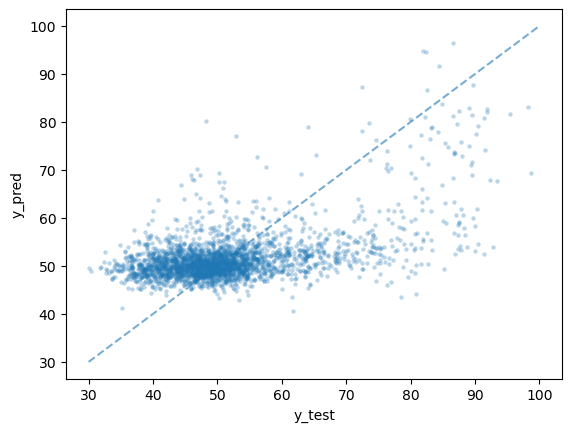

In [191]:
df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
ax = df.plot.scatter(x='y_test', y='y_pred', alpha=0.3, lw=0, s=10)
# sns.scatter(data=df, x='y_test', y='y_pred', alpha=0.6)

ax.plot([30,100], [30,100], '--', alpha=0.6)
plt.show()